# Evaluating Clustering Model Results

Deciding whether a clustering scheme is "good" is more difficult to *define* compared to evaluation of learning algorithms. This is because the data is unlabeled. There is no "truth" to compare against to decide if the clusters split the data. Thus choosing between clustering schemes is largely subjective.

However we can impose criteria we would like a clustering scheme to satisfy. For instance we may want clusters to minimize within-cluster sum of squared "errors" (distance from the centroid) but not at the expense of having lots of clusters. We may decide then that the optimal number of clusters is the number of clusters that makes measure of error small without having many clusters. Other evaluation schemes exist as well.

We will look at evaluating these schemes when clustering the iris data using $k$-means. The two approaches I will show are the "elbow" approach and silhouette analysis.

## Clustering the Iris Dataset

The first example will demonstrate using $k$-means clustering for the iris dataset. I first load in that dataset.

In [1]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline

In [2]:
iris_obj = load_iris()
iris_data = iris_obj.data
species = iris_obj.target
iris_data[:5,:]

array([[ 5.1,  3.5,  1.4,  0.2],
       [ 4.9,  3. ,  1.4,  0.2],
       [ 4.7,  3.2,  1.3,  0.2],
       [ 4.6,  3.1,  1.5,  0.2],
       [ 5. ,  3.6,  1.4,  0.2]])

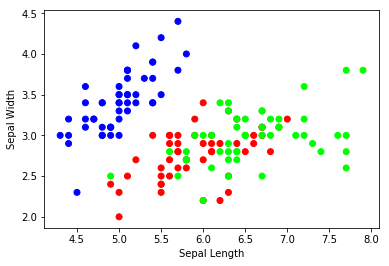

In [3]:
plt.scatter(iris_data[:, 0], iris_data[:, 1], c=species, cmap=plt.cm.brg)
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.show()

Next I import the `KMeans` object to perform $k$-means clustering, and then apply the method.

In [4]:
from sklearn.cluster import KMeans

In [5]:
irisclust = KMeans(n_clusters=3, init='random')    # Three clusters with cluster centers chosen as random dataset points
irisclust.fit(iris_data)
irisclust.cluster_centers_    # The coordinates of cluster centers

array([[ 5.006     ,  3.418     ,  1.464     ,  0.244     ],
       [ 6.85      ,  3.07368421,  5.74210526,  2.07105263],
       [ 5.9016129 ,  2.7483871 ,  4.39354839,  1.43387097]])

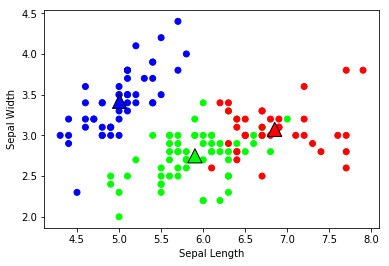

In [6]:
# Visualizing the clustering
plt.scatter(iris_data[:, 0], iris_data[:, 1], c=irisclust.predict(iris_data), cmap=plt.cm.brg)
plt.scatter(irisclust.cluster_centers_[:, 0], irisclust.cluster_centers_[:, 1],
            c=irisclust.predict(irisclust.cluster_centers_), cmap=plt.cm.brg, marker='^', s=200,
            edgecolors='k')
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.show()

## Finding the "Elbow"

Consider a plot of the sum of within-cluster squared errors:

$$\sum_{k=1}^{K} \sum_{i_k = 1}^{N_k} \|x_{i_k} - \mu_{k}\|^2$$

We want this number to be small, but we also want the number of clusters to be small. So we plot this quantity and choose the number of clusters $K$ that corresponds to the "elbow" of the plot.

The function below creates such a plot.

In [7]:
def wcsse_plot(data, max_clusters):
    """Plots sum of within-cluster sum of squared errors for clusters up to max_clusters for dataset data"""
    wcsse = np.arange(max_clusters) + 1
    for k in wcsse:
        wcsse[k - 1] = KMeans(n_clusters=k).fit(data).inertia_    # inertia is the sum described above
    plt.plot(np.arange(max_clusters) + 1, wcsse, marker='o')

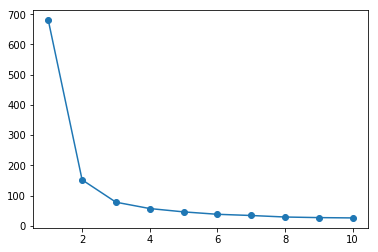

In [8]:
wcsse_plot(iris_data, 10)

Where is the elbow? We know that there are actually three species of iris flowers. Based on this plot, three clusters isn't a bad choice; this is around where the "elbow" is.

## Silhouette Analysis

Let $a(i)$ be the average dissimilarity of data point $i$ to all other data points in its cluster, and $b(i)$ the average dissimilarity of data point $i$ to the data points in the next nearest cluster (other than the cluster to which data point $i$ has been assigned). The silhouette score for data point $i$ is then:

$$s(i) = \frac{b(i) - a(i)}{\max \left(a(i), b(i)\right)}$$

This is a number between -1 and 1. 1 means that data point $i$ is very different from clusters other than the cluster to which it has been assigned, while -1 (and any number less than zero) suggests that data point $i$ is in the wrong cluster. A value of 0 suggests that data point $i$ is on the border of belonging to one of at least two clusters.

If we average the silhouette scores of each data point, we get the average silhouette score. We prefer this number not to be small since this suggests that clusters are not highly dissimilar; there are likely too many.

We can use the silhouette scores to construct a silhouette plot. **scikit-learn** provides functions, `silhouette_samples()` and `silhouette_score()`, that computes the silhouette score of each data point and the average silhouette score, respectively. These can be used to construct a silhouette plot. I have written a function for doing so. (The code for writing this function was strongly influenced by [this example](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py) provided by **scikit-learn**'s documentation.)

In [9]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [10]:
def silhouette_plot(data, labels, metric="euclidean", xticks = True):
    """Creates a silhouette plot given a dataset and the labels corresponding to cluster assignment, and reports the
       average silhouette score"""
    silhouette_avg = silhouette_score(data, labels,
                                      metric=metric)    # The average silhouette score over the entire sample
    sample_silhouette_values = silhouette_samples(data, labels,
                                                  metric=metric)    # The silhouette score of each individual data point
    
    # This loop creates the silhouettes in the silhouette plot
    y_lower = 10    # For space between silhouettes
    for k in np.unique(labels):
        cluster_values = sample_silhouette_values[labels == k]
        cluster_values.sort()
        nk = len(cluster_values)
        y_upper = y_lower + nk
        color = cm.spectral(float(k) / len(np.unique(labels)))
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, cluster_values,
                          facecolor=color, edgecolor=color)
        plt.text(-0.05, y_lower + 0.5 * nk, str(k))
        y_lower = y_upper + 10
    
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    if xticks:
        plt.xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.yticks([])
    plt.xlabel("Silhouette Score")
    plt.ylabel("Cluster")
    plt.show()
    
    print("The average silhouette score is", silhouette_avg)

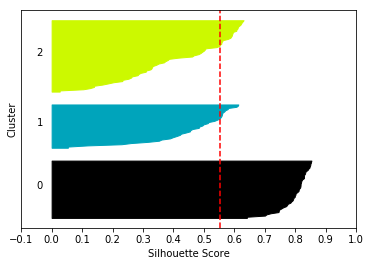

The average silhouette score is 0.552591944521


In [11]:
silhouette_plot(iris_data, irisclust.predict(iris_data))

When looking at a silhouette plot we do not want to see a cluster with most all (or nearly all) observations below the average silhouette score (as indicated by the red dashed line). This occurance would suggest a bad clustering.

In [12]:
def nclust_silhouette_kmeans(data, n_clusters):
    """A function for finding the k-means clustering with n clusters for a dataset and creating the corresponding silhouette
       plot"""
    labels = KMeans(n_clusters=n_clusters, init='random').fit_predict(data)
    silhouette_plot(data=data, labels=labels)

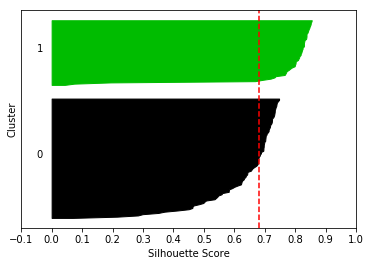

The average silhouette score is 0.680813620271


In [13]:
nclust_silhouette_kmeans(iris_data, 2)

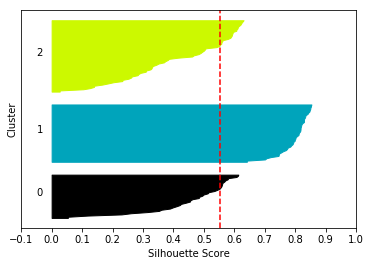

The average silhouette score is 0.552591944521


In [14]:
nclust_silhouette_kmeans(iris_data, 3)

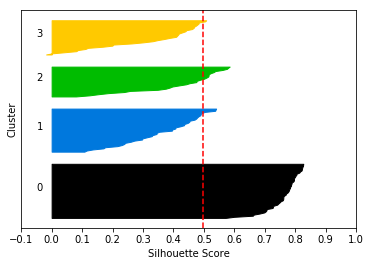

The average silhouette score is 0.497825690075


In [15]:
nclust_silhouette_kmeans(iris_data, 4)

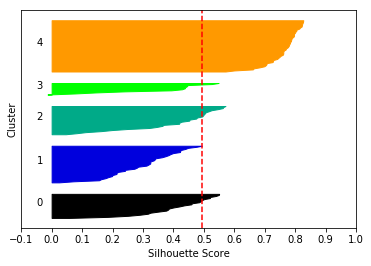

The average silhouette score is 0.492855591798


In [16]:
nclust_silhouette_kmeans(iris_data, 5)

The last two silhouette plots suggest that 4 and 5 clusters are not the right amounts since we end up with clusters whose silhouette scores are almost all below the mean. Either two or three clusters appear to be appropriate.

These analyses suggest that either two or three clusters are appropriate. We know that there are three species in this dataset but without this information we may need to decide which is appropriate. (It appears that one species, setosa, is very different from the other two. Look at plots of the flowers' petal length and petal width if you don't believe me.) Any number above three, though, is clearly inappropriate, as indicated by these plots.